# Hotel Booking Analysis

In [4]:
#Libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
hotel_df = pd.read_csv("hotel_bookings.csv")

In [ ]:
# Quick look 
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
hotel_df.shape

(119390, 32)

In [ ]:
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [ ]:
# It is better to copy original dataset, it can be needed in some cases.
data = hotel_df.copy()

# 1. EDA

### Cancellations by repeated guests

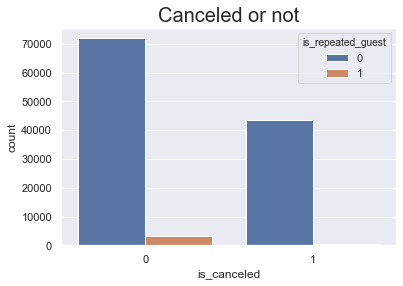

In [ ]:
sns.set(style = "darkgrid")
plt.title("Canceled or not", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = data)

There is no surprise that repeated guests do not cancel their reservations. Of course there are some exceptions.
Also most of the customers are not repeated guests.

### Boxplot Distribution of Nights Spent at Hotels by Market Segment and Hotel Type 

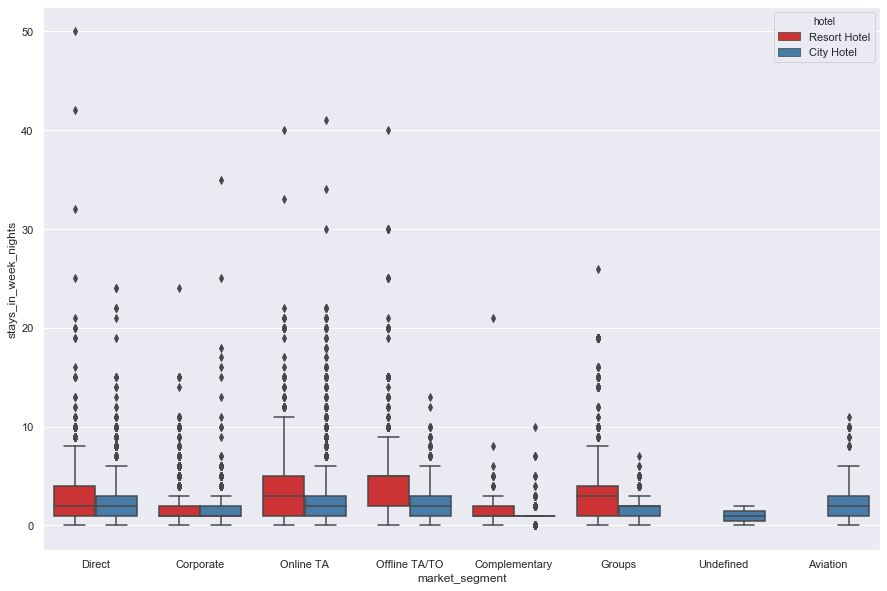

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = "market_segment", y = "stays_in_week_nights", data = data, hue = "hotel", palette = 'Set1');

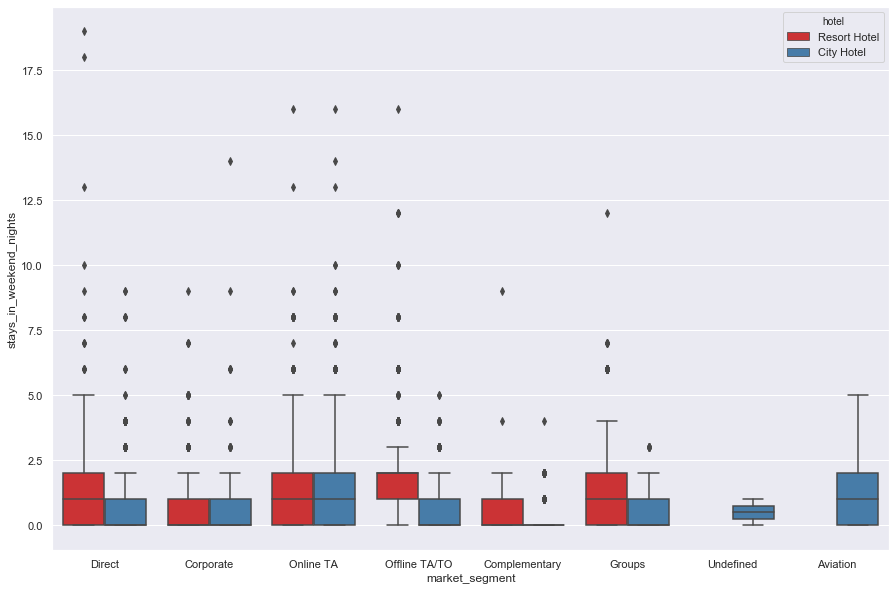

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x = "market_segment", y = "stays_in_weekend_nights", data = data, hue = "hotel", palette = 'Set1');

### Countplot Distribution of Market Segments

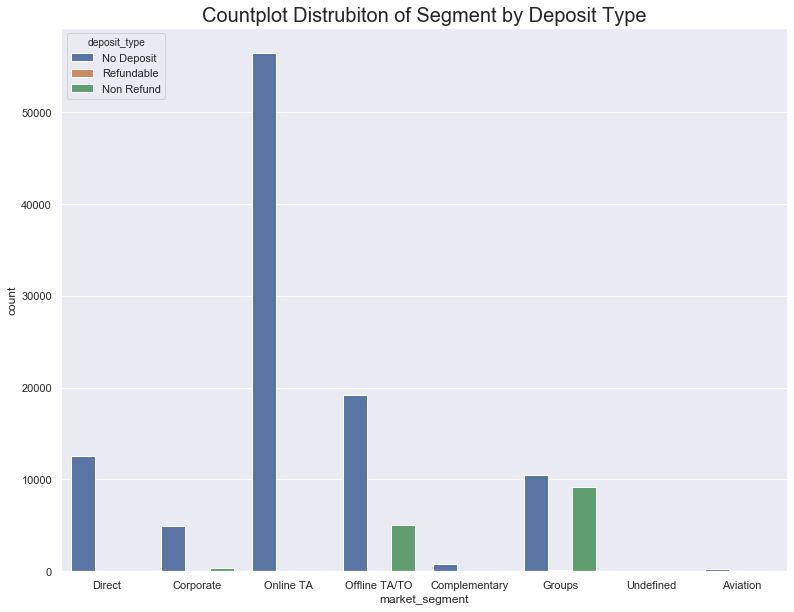

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distrubiton of Segment by Deposit Type", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'deposit_type', data = data)

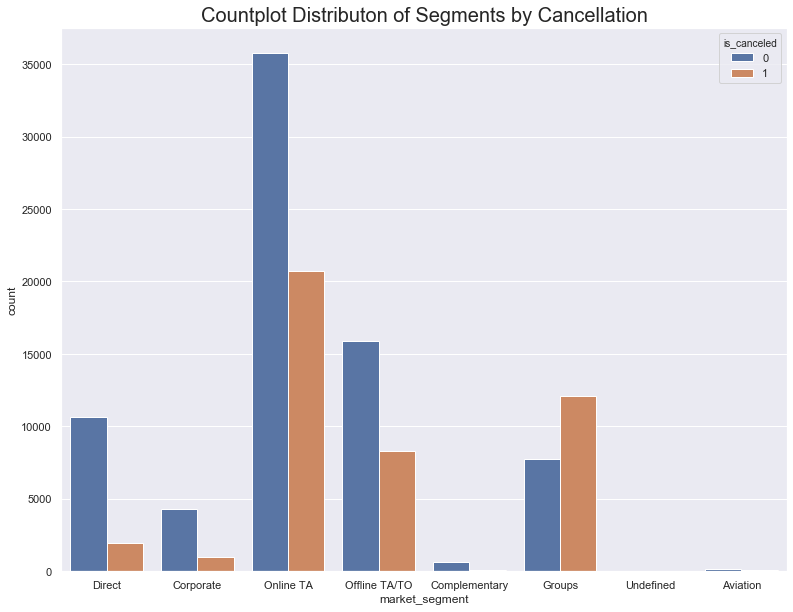

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Segments by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'is_canceled', data = data)

Looking at Offline TA/TO and Groups, the situations where the deposit was received were only in the scenarios where the groups came. It is quite logical to apply a deposit for a large number of customers who will fill important amount of the hotel capacity.

As a first thought, I expected the cancellation rate in the market segments where a deposit is applied to be lower than the other segments where no deposit applied. But when we look at the cancellations according to the segments in the other visualization, it seems that this is not the case. 

- Groups segment has cancellation rate more than 50%.
- Offline TA/TO (Travel Agents/Tour Operators) and Online TA has cancellation rate more than 33%.
- Direct segment has cancellation rate less than 20%.

It is surprising that the cancellation rate in these segments is high despite the application of a deposit. The fact that cancellations are made collectively like reservations may explain this situation a bit.

Cancellation rates for online reservations are as expected in a dynamic environment where the circulation is high.

Another situation that took my attention is that the cancellation rate in the direct segment is so low. At this point, I think that a mutual trust relationship has been established in case people are communicating one to one. I will not dwell on this much, but I think there is a psychological factor here.

### Density Curve of Lead Time by Cancelation

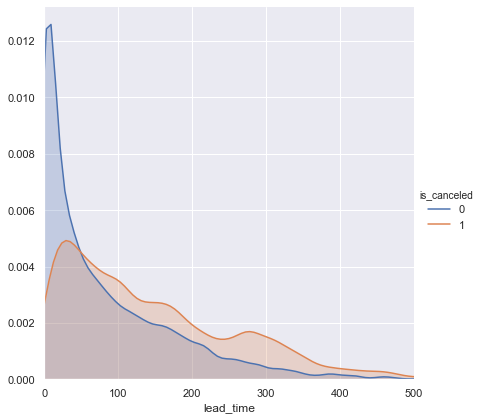

In [ ]:
(sns.FacetGrid(data, hue = 'is_canceled',
             height = 6,
             xlim = (0,500))
    .map(sns.kdeplot, 'lead_time', shade = True)
    .add_legend());

While lead time is more than roughly 60, people tend to cancel their reservations (cancellation rate is higher after this point). 
Also people want their holiday or work plans resulted in 100 days which equals to half of the data.

### Monthly Cancellations and Customers by Hotel Types

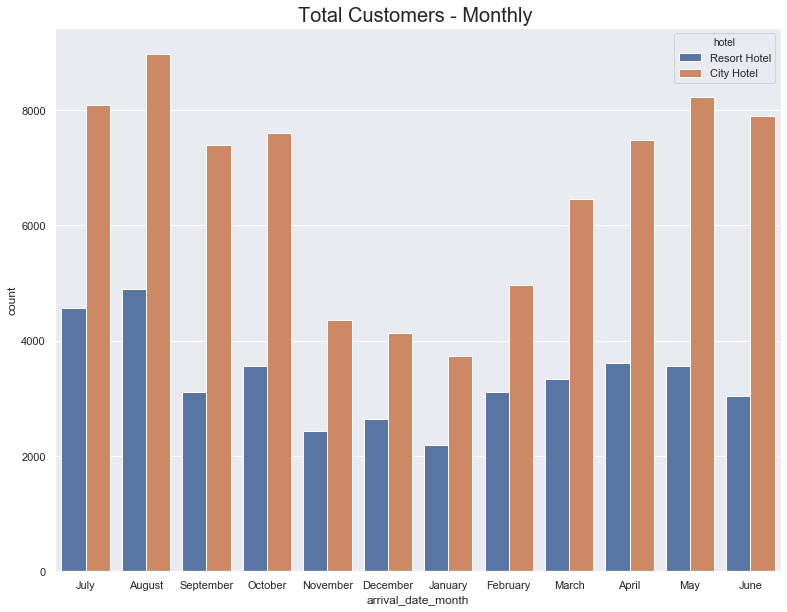

In [ ]:
plt.figure(figsize =(13,10))
sns.set(style="darkgrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = data)

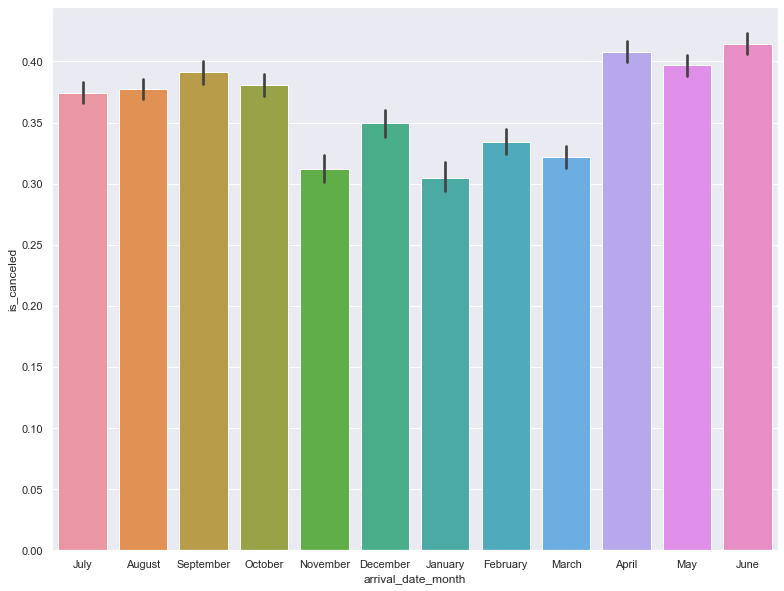

In [ ]:
plt.figure(figsize = (13,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', data = data);

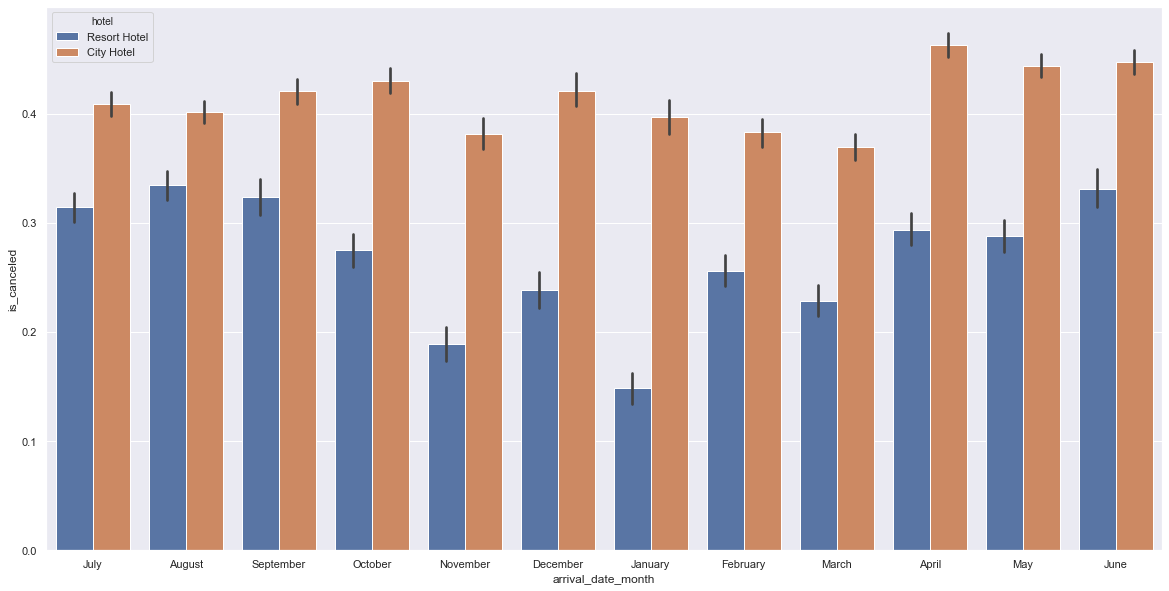

In [ ]:
plt.figure(figsize = (20,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', hue = 'hotel', data = data);

### what is the best year in booking? ###

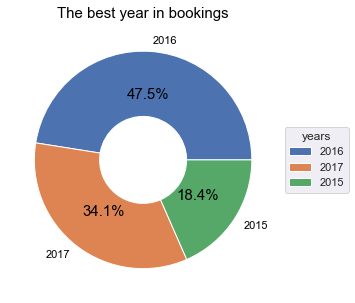

In [ ]:

year_counts=data.arrival_date_year.value_counts()
year_counts

fig, ax = plt.subplots(figsize=(15,5), subplot_kw=dict(aspect="equal"))
wedges, texts,autotexts = ax.pie(year_counts.values, labels=year_counts.index,autopct='%1.1f%%',textprops=dict(color="black"),
wedgeprops = {'width' : 0.6})
ax.legend(wedges, year_counts.index,
          title="years",
          loc="center left",
          bbox_to_anchor=(1, 0, 0, 1))# anchor of legend(position)
plt.setp(autotexts, size=15)#data inside the circle
ax.set_title("The best year in bookings",size=15,color='Black')

plt.show()


 ### What is the best hotel in each year?###

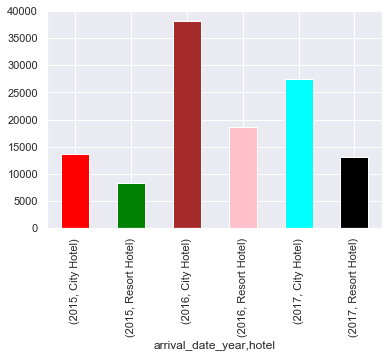

In [ ]:
data.groupby('arrival_date_year')['hotel'].value_counts().plot(kind='bar',
 color= ['red', 'green', 'brown','pink', 'cyan', 'black'])

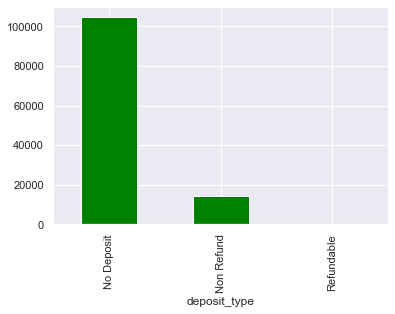

In [ ]:
data.groupby(['deposit_type']).size().plot.bar(color='green')

In [ ]:

data['is_canceled'] = data.is_canceled.replace([1,0], ['canceled', 'not_canceled'])
canceled_data = data['is_canceled']

country_visitors = data[data['is_canceled'] == 'not_canceled'].groupby(['country']).size().reset_index(name = 'count')

# We will be using Plotly.express to plot a choropleth map. Big fan of Plotly here!
import plotly.express as px

px.choropleth(country_visitors,
                    locations = "country",
                    color= "count", 
                    hover_name= "country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of visitors")

ModuleNotFoundError: No module named 'plotly'

Looking at the first graph, it can be seen that the city hotels have more customers in all months. Considering proportionally, resort hotels seem to be a little closer to city hotels in summer.

An important interpretation can be made by examining three graphics together. Fewer customers come in the winter months, so when we look at the cancellation rates, it is quite normal that it appears less in the winter months. The point to be noted on these months is that the cancellation rates of city hotels are almost equal to other months even in winter. The fact that the total cancellation rates of the winter months are low is that the cancellation rates of the resort hotels are low in these months.
In short, the possibility of cancellation of resort hotels in winter is very low. This information can be a very important factor when predicting 'is_canceled'.

# Preprocessing 
### (Missing Values, Feature Engineering and Standardization)

In [ ]:
hotel_data = hotel_df.copy()

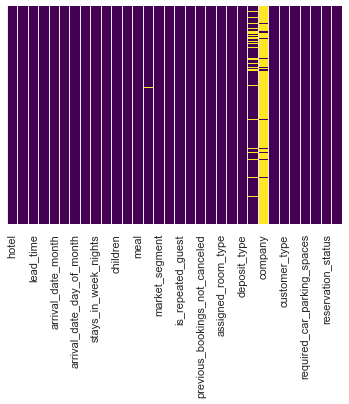

In [ ]:
sns.heatmap(hotel_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
print("# of NaN in each columns:", data.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [ ]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

print('Missing value ratios:\nCompany: {}\nAgent: {}\nCountry: {}'.format(perc_mv(hotel_data, hotel_data['company']),
                                                                                   perc_mv(hotel_data, hotel_data['agent']),
                                                                                   perc_mv(hotel_data, hotel_data['country'])))

Missing value ratios:
Company: 94.30689337465449
Agent: 13.686238378423655
Country: 0.40874445095904177


As we can see 94.3% of company column are missing values. Therefore we do not have enough values to fill the rows of company column by predicting, filling by mean etc. It seems that the best option is dropping company column.

13.68% of agent column are missing values, there is no need to drop agent column. But also we should not drop the rows because 13.68% of data is really huge amount and those rows have the chance to have crucial information. There are 333 unique agent, since there are too many agents they may not be predictable. 
Also NA values can be the agents that are not listed in present 333 agents. We can't predict agents and since missing values are 13% of all data we can't drop them too. I will decide what to do about agent after correlation section.

It will not be a problem if we drop the rows that have missing values in country column. Still, I will wait for correlation.

In [ ]:
# company is dropped
hotel_data = hotel_data.drop(['company'], axis = 1)

In [ ]:
# We have also 4 missing values in children column. If there is no information about children, In my opinion those customers do not have any children.
hotel_data['children'] = hotel_data['children'].fillna(0)

### Handling Features

We should check the features to create some more meaningful variables and reduce the number of features if it is possible.

In [ ]:
hotel_data.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [ ]:
# I wanted to label them manually. I will do the rest with get.dummies or label_encoder.
hotel_data['hotel'] = hotel_data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

hotel_data['arrival_date_month'] = hotel_data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [ ]:
hotel_data = hotel_data.drop(columns = ['reservation_status_date'])

After correlation we will decide what to do about country, agent and total_nights.

### Correlation

In [ ]:
hotel_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status'],
      dtype='object')

In [ ]:
# Lets copy data to check the correlation between variables. 
cor_data = hotel_data.copy()

In [ ]:
le = LabelEncoder()

In [ ]:
# This data will not be used while predicting cancellation. This is just for checking correlation.
cor_data['meal'] = le.fit_transform(cor_data['meal'])
cor_data['distribution_channel'] = le.fit_transform(cor_data['distribution_channel'])
cor_data['reserved_room_type'] = le.fit_transform(cor_data['reserved_room_type'])
cor_data['assigned_room_type'] = le.fit_transform(cor_data['assigned_room_type'])
cor_data['agent'] = le.fit_transform(cor_data['agent'])
cor_data['customer_type'] = le.fit_transform(cor_data['customer_type'])
cor_data['reservation_status'] = le.fit_transform(cor_data['reservation_status'])
cor_data['market_segment'] = le.fit_transform(cor_data['market_segment'])

In [ ]:
cor_data.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
hotel,1.000000,0.136531,0.075381,0.035267,0.001817,0.001270,-0.001862,-0.186596,-0.234020,-0.013183,...,-0.249677,-0.307834,-0.072820,-0.158500,0.072432,0.047531,0.096719,-0.218873,-0.043390,-0.124331
is_canceled,0.136531,1.000000,0.293123,0.016660,0.011022,0.008148,-0.006130,-0.001791,0.024765,0.060017,...,-0.061282,-0.176028,-0.144381,-0.127883,0.054186,-0.068140,0.047557,-0.195498,-0.234658,-0.917196
lead_time,0.075381,0.293123,1.000000,0.040142,0.131424,0.126871,0.002268,0.085671,0.165799,0.119519,...,-0.106089,-0.172219,0.000149,-0.171430,0.170084,0.073403,-0.063077,-0.116451,-0.095712,-0.302175
arrival_date_year,0.035267,0.016660,0.040142,1.000000,-0.527739,-0.540561,-0.000221,0.021497,0.030883,0.029635,...,0.092809,0.036141,0.030872,-0.017723,-0.056497,-0.006149,0.197580,-0.013684,0.108531,-0.017683
arrival_date_month,0.001817,0.011022,0.131424,-0.527739,1.000000,0.995105,-0.026063,0.018440,0.019212,0.028534,...,-0.007923,-0.006378,0.004809,-0.000799,0.019045,-0.029753,0.079315,0.000257,0.028026,-0.021090
arrival_date_week_number,0.001270,0.008148,0.126871,-0.540561,0.995105,1.000000,0.066809,0.018208,0.015558,0.025909,...,-0.007997,-0.005684,0.005508,0.001638,0.022933,-0.028432,0.075791,0.001920,0.026149,-0.017387
arrival_date_day_of_month,-0.001862,-0.006130,0.002268,-0.000221,-0.026063,0.066809,1.000000,-0.016354,-0.028174,-0.001566,...,0.016929,0.011646,0.010613,-0.002271,0.022728,0.012188,0.030245,0.008683,0.003062,0.011460
stays_in_weekend_nights,-0.186596,-0.001791,0.085671,0.021497,0.018440,0.018208,-0.016354,1.000000,0.498969,0.091871,...,0.142083,0.086643,0.063281,-0.110284,-0.054151,-0.109220,0.049342,-0.018554,0.072671,0.008558
stays_in_week_nights,-0.234020,0.024765,0.165799,0.030883,0.019212,0.015558,-0.028174,0.498969,1.000000,0.092976,...,0.168616,0.100795,0.096209,-0.110354,-0.002020,-0.127223,0.065237,-0.024859,0.068192,-0.021607
adults,-0.013183,0.060017,0.119519,0.029635,0.028534,0.025909,-0.001566,0.091871,0.092976,1.000000,...,0.211434,0.144779,-0.051673,-0.169782,-0.008283,-0.101756,0.230641,0.014785,0.122884,-0.071802


In [ ]:
cor_data.corr()["is_canceled"].sort_values()

reservation_status               -0.917196
total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
assigned_room_type               -0.176028
booking_changes                  -0.144381
agent                            -0.127883
is_repeated_guest                -0.084793
customer_type                    -0.068140
reserved_room_type               -0.061282
previous_bookings_not_canceled   -0.057358
babies                           -0.032491
meal                             -0.017678
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
children                          0.005036
arrival_date_week_number          0.008148
arrival_date_month                0.011022
arrival_date_year                 0.016660
stays_in_week_nights              0.024765
adr                               0.047557
days_in_waiting_list              0.054186
market_segment                    0.059338
adults                            0.060017
previous_ca

As we can see in the sorted list, reservation_status seems to be most impactful feature. With that information accuracy rate should be really high. It can be better to drop reservation_status column to see how other features can predict. I am going to try both.

Impacts of three feature that are created:
- deposit_given = 0,48131
- is_family = -0,01327
- total_customer = 0,04504

Apart from that, I will not use arrival_date_week_number, stays_in_weekend_nights and arrival_date_day_of_month since their importances are really low while predicting cancellations. 

Also, still we have some missing values in agent column. It has nice importance on predicting cancellation but since the missing values are equal to 13% of the total data it is better to drop that column. It has a lot of class inside of it otherwise we could try predicting missing values but they may misguide the predictions.

In [ ]:
hotel_data = hotel_data.drop(columns = ['country', 'agent'], axis = 1)

 In the correlation part, we have seen the impact of reservation status. Reservation status dominates other features totally. By keeping reservation_status in data, it is possible to achieve 100% accuracy rate because that feature is direct way to predict cancellations, its like cheating. For the sake of analysis I will drop reservation_status and continue analysis without it.

In [ ]:
hotel_data = hotel_data.drop(columns = ['reservation_status'], axis = 1)

In [ ]:
hotel_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [ ]:
#one-hot-encoding
df1 = pd.get_dummies(data = hotel_data, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'deposit_type'])

In [ ]:
df1.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'market_segment_Aviation',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'reserved_room_type_A', 'reserved

# ML Models Implement

In [ ]:
X = df1.drop(["is_canceled"], axis=1)
y = df1["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

### Logistic Regression Model

Confusion Matrix:
[[20953  1525]
 [ 5206  8133]]
--------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     22478
           1       0.84      0.61      0.71     13339

    accuracy                           0.81     35817
   macro avg       0.82      0.77      0.78     35817
weighted avg       0.82      0.81      0.80     35817

--------------------------------------------------------
Accuracy Score:
0.8120724795488176


Text(30.5, 0.5, 'Truth')

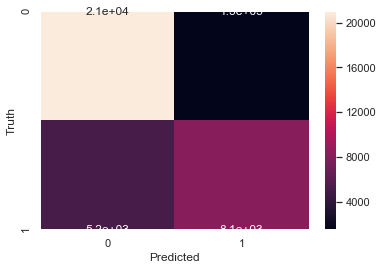

In [ ]:
Log_Reg_Model = LogisticRegression().fit(X_train, y_train)

Log_predictions = Log_Reg_Model.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,Log_predictions))
print('--------------------------------------------------------')

print('Classification Report:')
print(classification_report(y_test, Log_predictions))
print('--------------------------------------------------------')

print('Accuracy Score:')
print(accuracy_score(y_test,Log_predictions))

sns.heatmap(confusion_matrix(y_test,Log_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Cancellations')
    plt.ylabel('Hotel_bookings')

    plt.show()
    plt.close()

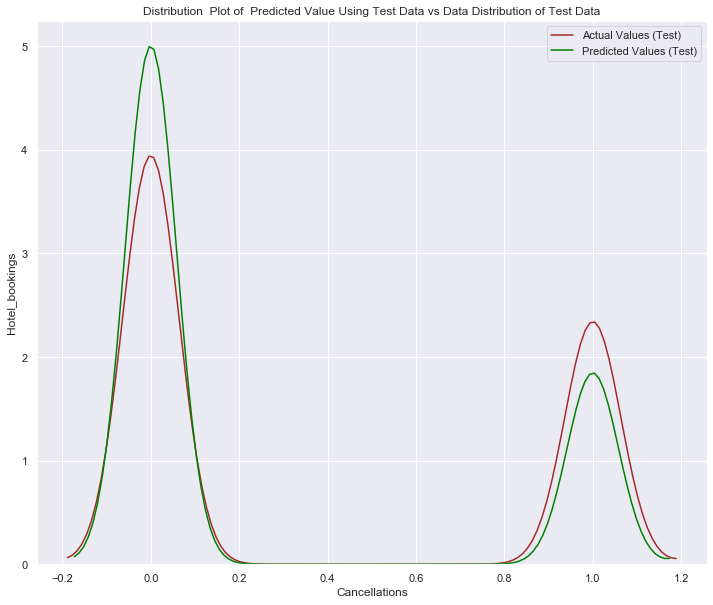

In [ ]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,Log_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### Gaussian Naive Bayes Model

Confusion Matrix:
[[11195 11283]
 [ 2458 10881]]
--------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.50      0.62     22478
           1       0.49      0.82      0.61     13339

    accuracy                           0.62     35817
   macro avg       0.66      0.66      0.62     35817
weighted avg       0.70      0.62      0.62     35817

--------------------------------------------------------
Accuracy Score:
0.6163553619789486


Text(30.5, 0.5, 'Truth')

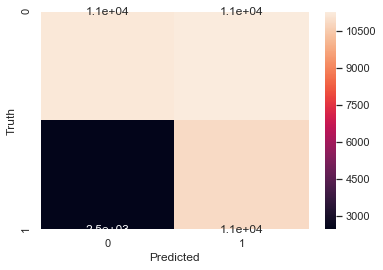

In [ ]:
gaussian_model = GaussianNB().fit(X_train,y_train)

gaussian_predictions = gaussian_model.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,gaussian_predictions))
print('--------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test,gaussian_predictions))
print('--------------------------------------------------------')
print('Accuracy Score:')
print(accuracy_score(y_test,gaussian_predictions))

sns.heatmap(confusion_matrix(y_test,gaussian_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

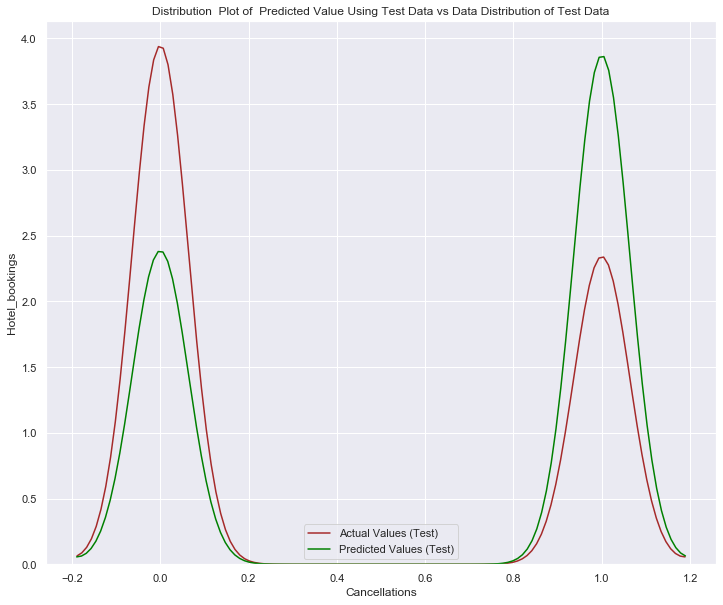

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Cancellations')
    plt.ylabel('Hotel_bookings')

    plt.show()
    plt.close()
    
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,gaussian_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### KNN Model

Confusion Matrix:
[[18235  4243]
 [ 3806  9533]]
--------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     22478
           1       0.69      0.71      0.70     13339

    accuracy                           0.78     35817
   macro avg       0.76      0.76      0.76     35817
weighted avg       0.78      0.78      0.78     35817

--------------------------------------------------------
Accuracy Score:
0.77527431108133


Text(30.5, 0.5, 'Truth')

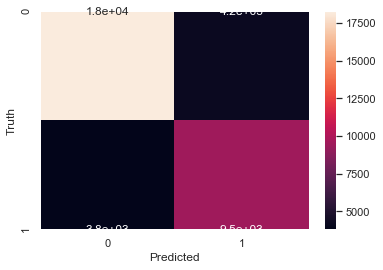

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

knn_predictions = knn_model.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,knn_predictions))
print('--------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test,knn_predictions))
print('--------------------------------------------------------')
print('Accuracy Score:')
print(accuracy_score(y_test,knn_predictions))

sns.heatmap(confusion_matrix(y_test,knn_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

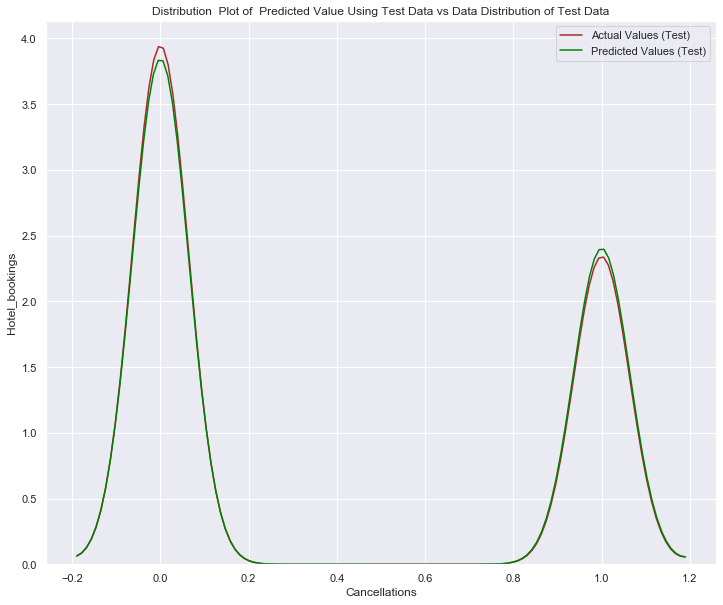

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Cancellations')
    plt.ylabel('Hotel_bookings')

    plt.show()
    plt.close()
    
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,knn_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### Support Vector Classification Model

In [ ]:
# svm_model = SVC(kernel='linear').fit(X_train,y_train)

# svm_predictions = svm_model.predict(X_test)

# print('Confusion Matrix:')
# print(confusion_matrix(y_test,svm_predictions))
# print('--------------------------------------------------------')
# print('Classification Report:')
# print(classification_report(y_test,svm_predictions))
# print('--------------------------------------------------------')
# print('Accuracy Score:')
# print(accuracy_score(y_test,svm_predictions))

# sns.heatmap(confusion_matrix(y_test,svm_predictions), annot=True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

In [ ]:
# def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
#     width = 12
#     height = 10
#     plt.figure(figsize=(width, height))

#     ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
#     ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

#     plt.title(Title)
#     plt.xlabel('Cancellations')
#     plt.ylabel('Hotel_bookings')

#     plt.show()
#     plt.close()
    
# Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
# DistributionPlot(y_test,svm_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### Decision Tree Model

In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth = 12).fit(X_train,y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,decision_tree_predictions))
print('--------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test,decision_tree_predictions))
print('--------------------------------------------------------')
print('Accuracy Score:')
print(accuracy_score(y_test,decision_tree_predictions))

sns.heatmap(confusion_matrix(y_test,decision_tree_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

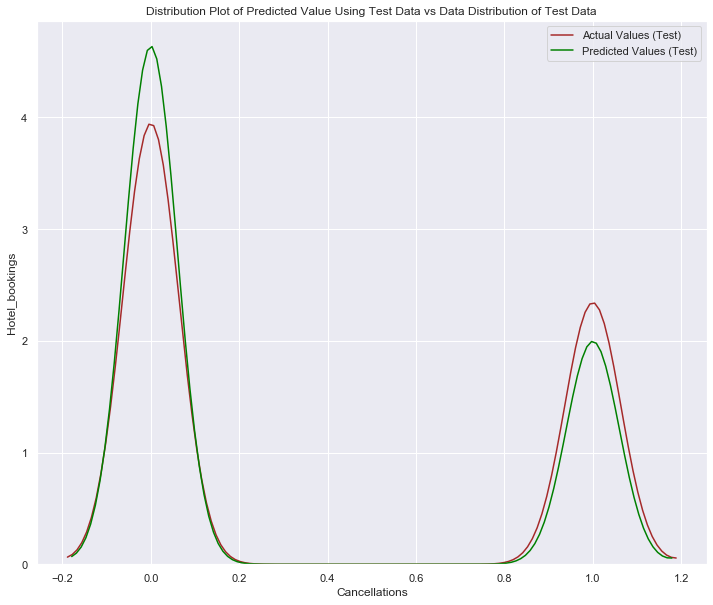

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Cancellations')
    plt.ylabel('Hotel_bookings')

    plt.show()
    plt.close()
    
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,decision_tree_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### Random Forest Model

Confusion Matrix:
[[20937  1541]
 [ 3525  9814]]
--------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22478
           1       0.86      0.74      0.79     13339

    accuracy                           0.86     35817
   macro avg       0.86      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817

--------------------------------------------------------
Accuracy Score:
0.8585587849345283


Text(30.5, 0.5, 'Truth')

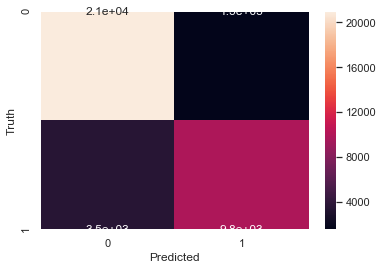

In [ ]:
random_tree_model = RandomForestClassifier().fit(X_train, y_train)   # need to make it 60 for better accuracy

random_forest_predictions = random_tree_model.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,random_forest_predictions))
print('--------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test,random_forest_predictions))
print('--------------------------------------------------------')
print('Accuracy Score:')
print(accuracy_score(y_test,random_forest_predictions))

sns.heatmap(confusion_matrix(y_test,random_forest_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

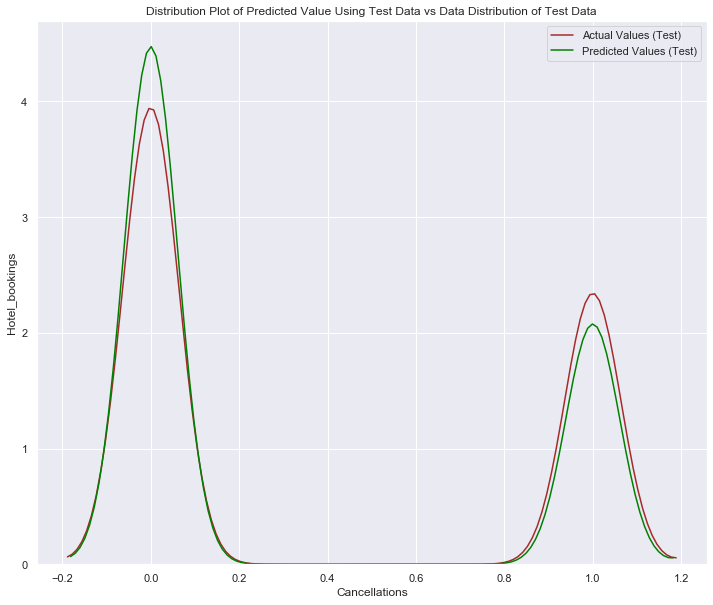

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="brown", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="green", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Cancellations')
    plt.ylabel('Hotel_bookings')

    plt.show()
    plt.close()
    
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,random_forest_predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

### Accuracy Chart of all Models

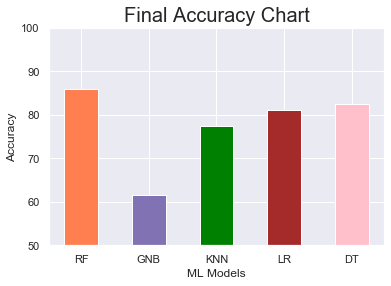

In [ ]:
# x-coordinates of left sides of bars  
left = [5,10,15,20,25]
  
# heights of bars 
height = [(accuracy_score(y_test,random_forest_predictions)) * 100, (accuracy_score(y_test,gaussian_predictions))* 100, (accuracy_score(y_test,knn_predictions))* 100 , (accuracy_score(y_test,Log_predictions)) * 100 , (accuracy_score(y_test,decision_tree_predictions)) * 100] 
  
# labels for bars 
tick_label = ['RF', 'GNB', 'KNN' , 'LR' , 'DT'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 2.5, color = ['coral','m', 'green' , 'brown' , 'pink' ]) 
plt.ylim(50,100)
  
# naming the x-axis 
plt.xlabel('ML Models') 
# naming the y-axis 
plt.ylabel('Accuracy') 
# plot title 
plt.title('Final Accuracy Chart', fontsize=20 ) 
  
# function to show the plot 
plt.show()

### Comparison Table of all Models